# Import encoded dataset

In [1]:
import pandas as pd

df_feat = pd.read_csv("stack_overflow_encoded.csv")

In [2]:
df_feat.head()

,YearsCode,YearsCodePro,CompTotal,WorkExp,EdLevel_encoded,is_full_time,is_part_time,is_self_employed,is_retired,is_employment_unspecified,...,Knowledge_7_encoded,Knowledge_7_is_missing,Knowledge_8_encoded,Knowledge_8_is_missing,Frequency_1_encoded,Frequency_1_is_missing,Frequency_2_encoded,Frequency_2_is_missing,Frequency_3_encoded,Frequency_3_is_missing
0,18.0,9.0,285000.0,10.0,4.0,1,0,0,0,0,...,4,0,5,0,1,0,4,0,0,0
1,27.0,23.0,250000.0,23.0,4.0,1,0,0,0,0,...,4,0,4,0,3,0,3,0,2,0
2,12.0,7.0,156000.0,7.0,4.0,1,0,0,0,0,...,4,0,4,0,1,0,4,0,1,0
3,4.0,3.0,135000.0,4.0,2.0,1,0,0,0,0,...,4,0,3,0,1,0,2,0,1,0
4,5.0,3.0,80000.0,5.0,4.0,1,0,0,0,0,...,3,1,3,1,0,1,0,1,0,1


# Comprehensive feature engineering

## Split features and target

In [3]:
X = df_feat.drop('CompTotal', axis=1)
y = df_feat['CompTotal']

# Create train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (8911, 206)
Testing set shape: (2228, 206)


## Handle Missing Values

In [4]:
# Copy original sets
X_train_fe = X_train.copy()
X_test_fe = X_test.copy()

# Identify features with missing values
missing = X_train_fe.isnull().sum()
missing = missing[missing > 0]
missing_percent = (missing / len(X_train_fe)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_percent
}).sort_values(by='Missing Count', ascending=False)

print("Features with missing values:")
display(missing_df)

# Check distribution summary for each missing feature
for col in missing_df.index:
    print(f"\n--- {col} ---")
    print(X_train_fe[col].describe())

    if X_train_fe[col].dtype == 'object':
        print("\nTop categories:")
        print(X_train_fe[col].value_counts(dropna=False).head())

Features with missing values:


,Missing Count,Missing %
WorkExp,2597,29.143755
OrgSize_encoded,136,1.526204
Age_encoded,128,1.436427
EdLevel_encoded,25,0.280552
YearsCodePro,18,0.201998
YearsCode,3,0.033666



--- WorkExp ---
count    6314.000000
mean       13.567944
std        10.000961
min         0.000000
25%         6.000000
50%        11.000000
75%        20.000000
max        50.000000
Name: WorkExp, dtype: float64

--- OrgSize_encoded ---
count    8775.000000
mean        4.780285
std         2.294392
min         0.000000
25%         3.000000
50%         4.000000
75%         7.000000
max         8.000000
Name: OrgSize_encoded, dtype: float64

--- Age_encoded ---
count    8783.000000
mean        2.664465
std         0.997958
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: Age_encoded, dtype: float64

--- EdLevel_encoded ---
count    8886.000000
mean        3.906144
std         1.032054
min         0.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         6.000000
Name: EdLevel_encoded, dtype: float64

--- YearsCodePro ---
count    8893.000000
mean       12.268807
std         9.643570
min         0.5

In [5]:
# Define function to safely impute values
def impute_values(df, column, value):
    df = df.copy()
    df[column] = df[column].fillna(value)
    return df

### Handle missing workexp

In [6]:
# Handle WorkExp (29.14% missing)
if 'YearsCodePro' in X_train_fe.columns and 'Age_encoded' in X_train_fe.columns:
    # First handle YearsCodePro
    ypro_median = X_train_fe['YearsCodePro'].median()
    X_train_fe = impute_values(X_train_fe, 'YearsCodePro', ypro_median)
    X_test_fe = impute_values(X_test_fe, 'YearsCodePro', ypro_median)

    # Create model for WorkExp prediction
    from sklearn.ensemble import RandomForestRegressor
    work_exp_model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Prepare data for model
    features_for_workexp = ['YearsCodePro', 'Age_encoded']
    mask = X_train_fe['WorkExp'].notna()

    # Train model
    work_exp_model.fit(
        X_train_fe.loc[mask, features_for_workexp],
        X_train_fe.loc[mask, 'WorkExp']
    )

    # Predict and fill missing values
    missing_mask = X_train_fe['WorkExp'].isna()
    predicted_values = work_exp_model.predict(X_train_fe.loc[missing_mask, features_for_workexp])
    X_train_fe = X_train_fe.copy()
    X_train_fe.loc[missing_mask, 'WorkExp'] = predicted_values

    missing_mask_test = X_test_fe['WorkExp'].isna()
    predicted_values_test = work_exp_model.predict(X_test_fe.loc[missing_mask_test, features_for_workexp])
    X_test_fe = X_test_fe.copy()
    X_test_fe.loc[missing_mask_test, 'WorkExp'] = predicted_values_test
else:
    work_median = X_train_fe['WorkExp'].median()
    X_train_fe = impute_values(X_train_fe, 'WorkExp', work_median)
    X_test_fe = impute_values(X_test_fe, 'WorkExp', work_median)

print("WorkExp imputation completed")

WorkExp imputation completed


### Handle remaining features with median/mode imputation

In [7]:
# OrgSize_encoded
orgsize_median = X_train_fe['OrgSize_encoded'].median()
X_train_fe = impute_values(X_train_fe, 'OrgSize_encoded', orgsize_median)
X_test_fe = impute_values(X_test_fe, 'OrgSize_encoded', orgsize_median)
print("OrgSize_encoded imputation completed")

# Age_encoded
age_median = X_train_fe['Age_encoded'].median()
X_train_fe = impute_values(X_train_fe, 'Age_encoded', age_median)
X_test_fe = impute_values(X_test_fe, 'Age_encoded', age_median)
print("Age_encoded imputation completed")

# EdLevel_encoded
edlevel_mode = X_train_fe['EdLevel_encoded'].mode()[0]
X_train_fe = impute_values(X_train_fe, 'EdLevel_encoded', edlevel_mode)
X_test_fe = impute_values(X_test_fe, 'EdLevel_encoded', edlevel_mode)
print("EdLevel_encoded imputation completed")

# YearsCodePro
ypro_median = X_train_fe['YearsCodePro'].median()
X_train_fe = impute_values(X_train_fe, 'YearsCodePro', ypro_median)
X_test_fe = impute_values(X_test_fe, 'YearsCodePro', ypro_median)
print("YearsCodePro imputation completed")

# YearsCode
ycode_median = X_train_fe['YearsCode'].median()
X_train_fe = impute_values(X_train_fe, 'YearsCode', ycode_median)
X_test_fe = impute_values(X_test_fe, 'YearsCode', ycode_median)
print("YearsCode imputation completed")

OrgSize_encoded imputation completed
Age_encoded imputation completed
EdLevel_encoded imputation completed
YearsCodePro imputation completed
YearsCode imputation completed


In [8]:
# Verify no missing values remain
print("\nVerifying missing values after imputation:")
print("Train NaNs:", X_train_fe.isnull().sum().sum())
print("Test NaNs:", X_test_fe.isnull().sum().sum())


Verifying missing values after imputation:
Train NaNs: 0
Test NaNs: 0


## Visualize distributions

In [9]:
import numpy as np

print(f"Initial shape: {X_train_fe.shape}")

# Select numeric features excluding target
num_cols = X_train_fe.select_dtypes(include=['float64', 'int64']).columns.drop("CompTotal", errors="ignore")

# Skip binary features (log on [0,1] = waste)
non_binary_cols = [col for col in num_cols if X_train_fe[col].nunique() > 2]

Initial shape: (8911, 206)


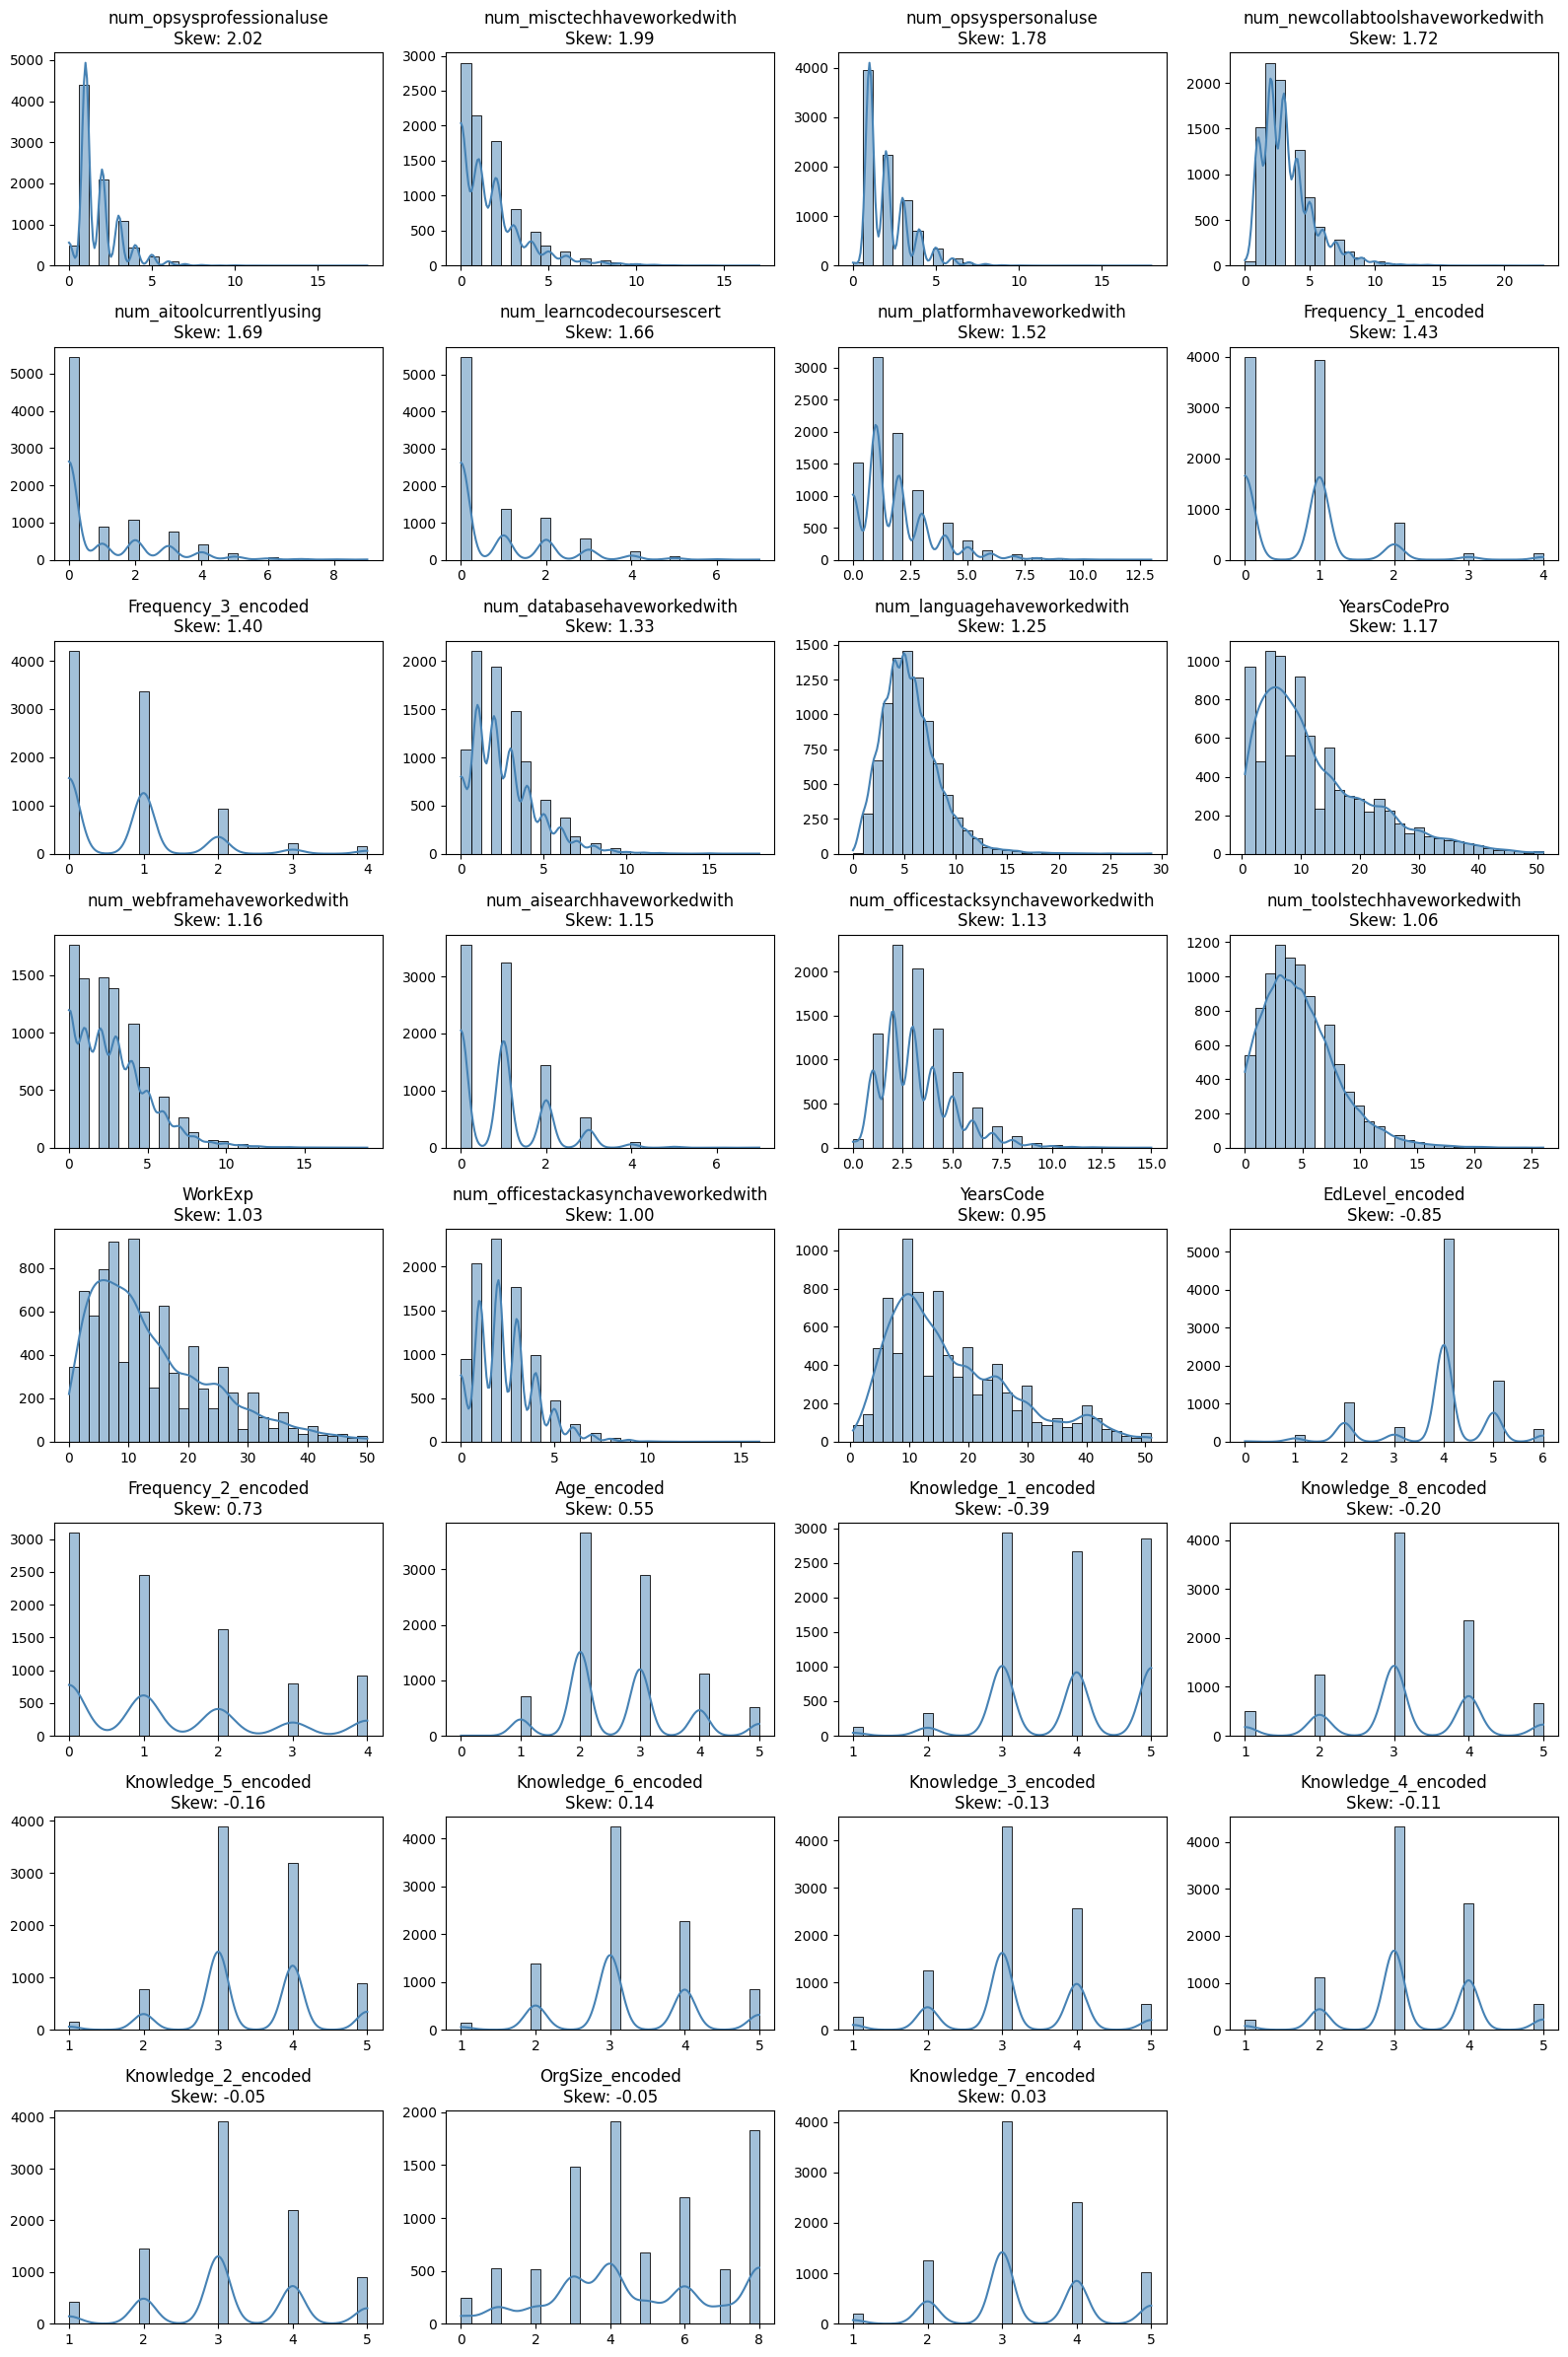

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by absolute skew
sorted_cols = X_train_fe[non_binary_cols].skew().abs().sort_values(ascending=False).index.tolist()

# Plot in batches
cols_per_row = 4
n_rows = int(np.ceil(len(sorted_cols) / cols_per_row))

plt.figure(figsize=(cols_per_row * 4, n_rows * 3))

for i, col in enumerate(sorted_cols, 1):
    plt.subplot(n_rows, cols_per_row, i)
    sns.histplot(X_train_fe[col].dropna(), kde=True, bins=30, color='steelblue')
    plt.title(f"{col}\nSkew: {X_train_fe[col].skew():.2f}")
    plt.xlabel("")
    plt.ylabel("")

plt.tight_layout()
plt.show()

## Log transform skewed features

In [11]:
# After all other feature engineering is done
num_cols = X_train_fe.select_dtypes(include=['float64', 'int64']).columns.drop("CompTotal", errors="ignore")

# Skip binary and already-nonlinear features
exclude_keywords = ['_log', '_squared', '_x_', 'Ratio', 'Combined']
non_binary_cols = [col for col in num_cols if X_train_fe[col].nunique() > 2 and not any(kw in col for kw in exclude_keywords)]

# Log only if still skewed
skewed_cols = [col for col in non_binary_cols if abs(X_train_fe[col].skew()) > 1]

# Apply log1p and concat
X_train_log = np.log1p(X_train_fe[skewed_cols])
X_test_log  = np.log1p(X_test_fe[skewed_cols])

X_train_log.columns = [f"{col}_log" for col in skewed_cols]
X_test_log.columns  = [f"{col}_log" for col in skewed_cols]

X_train_fe = pd.concat([X_train_fe, X_train_log], axis=1)
X_test_fe  = pd.concat([X_test_fe, X_test_log], axis=1)

print(f"Log-transformed: {skewed_cols}")
print(f"New shape: {X_train_fe.shape}")

Log-transformed: ['YearsCodePro', 'WorkExp', 'num_languagehaveworkedwith', 'num_databasehaveworkedwith', 'num_platformhaveworkedwith', 'num_webframehaveworkedwith', 'num_misctechhaveworkedwith', 'num_toolstechhaveworkedwith', 'num_newcollabtoolshaveworkedwith', 'num_opsyspersonaluse', 'num_opsysprofessionaluse', 'num_officestacksynchaveworkedwith', 'num_aisearchhaveworkedwith', 'num_aitoolcurrentlyusing', 'num_learncodecoursescert', 'Frequency_1_encoded', 'Frequency_3_encoded']
New shape: (8911, 223)


## Create Experience Level Binning

In [14]:
# Create bins for work exp
exp_bins = [-1, 1, 5, 10, 20, float('inf')]
exp_labels = ['Newbie (0-1)', 'Junior (2-5)', 'Mid (6-10)', 'Senior (11-20)', 'Expert (21+)']

# Binning work exp into career levels
X_train_fe['ExpLevel'] = pd.cut(X_train_fe['WorkExp'], bins=exp_bins, labels=exp_labels)
X_test_fe['ExpLevel'] = pd.cut(X_test_fe['WorkExp'], bins=exp_bins, labels=exp_labels)

# Convert to one-hot
train_exp_dummies = pd.get_dummies(X_train_fe['ExpLevel'], prefix='Exp')
test_exp_dummies = pd.get_dummies(X_test_fe['ExpLevel'], prefix='Exp')

# Concatenate
X_train_fe = pd.concat([X_train_fe, train_exp_dummies], axis=1)
X_test_fe = pd.concat([X_test_fe, test_exp_dummies], axis=1)

print("Created experience level bins:", train_exp_dummies.columns.tolist())
print(f"\nFinal shape binning: {X_train_fe.shape}")

Created experience level bins: ['Exp_Newbie (0-1)', 'Exp_Junior (2-5)', 'Exp_Mid (6-10)', 'Exp_Senior (11-20)', 'Exp_Expert (21+)']

Final shape binning: (8911, 229)


## Create Interaction Features

**Strategy**

To capture nuanced relationships between key variables, we engineered several interaction terms based on domain logic.

* We combined **Work Experience and Education** to create a `WorkExp_x_Education` feature. This captures how formal education might amplify or moderate the effect of years of experience.

* We added an `Education_x_OrgSize` feature to reflect how the value of education could vary depending on company size. For example, a degree might carry more weight in a larger organization with structured pay bands.

* We multiplied each **role indicator** (e.g. `is_data_scientist`, `is_engineering_manager`, etc.) with `WorkExp` to reflect role-specific experience. This lets the model treat five years of experience as more meaningful if the respondent is in a senior technical role.

* We introduced `Age_x_Exp` to represent alignment between career stage and actual coding or work exposure. Disparities here may reflect career changes or non-traditional paths.

* Lastly, we added interactions between **remote work type** (remote, hybrid, in-person) with both `OrgSize` and `EdLevel_encoded`. These help assess how work setting and background education interact across company types.

These interactions help the model pick up on real-world complexities that raw features may not capture individually.


In [15]:
role_cols = [col for col in X_train_fe.columns if col.startswith('is_')]
print("Role columns:", role_cols)

Role columns: ['is_full_time', 'is_part_time', 'is_self_employed', 'is_retired', 'is_employment_unspecified', 'is_remote', 'is_hybrid', 'is_inperson', 'is_developer_full_stack', 'is_developer_back_end', 'is_developer_front_end', 'is_developer_desktop_or_enterprise_applications', 'is_engineering_manager', 'is_other_please_specify', 'is_developer_embedded_applications_or_devices', 'is_developer_mobile', 'is_cloud_infrastructure_engineer', 'is_data_scientist_or_machine_learning_specialist']


In [16]:
# Define non-role flags (work arrangements, etc.)
non_role_flags = [
    'is_full_time', 'is_part_time', 'is_self_employed',
    'is_retired', 'is_employment_unspecified',
    'is_remote', 'is_hybrid', 'is_inperson'
]

# Filter all is_ columns that are NOT in non-role and NOT log features
role_cols = [
    col for col in X_train_fe.columns
    if col.startswith('is_') and
       not col.endswith('_log') and
       col not in non_role_flags
]

print("Final role columns for interaction:", role_cols)

Final role columns for interaction: ['is_developer_full_stack', 'is_developer_back_end', 'is_developer_front_end', 'is_developer_desktop_or_enterprise_applications', 'is_engineering_manager', 'is_other_please_specify', 'is_developer_embedded_applications_or_devices', 'is_developer_mobile', 'is_cloud_infrastructure_engineer', 'is_data_scientist_or_machine_learning_specialist']


In [17]:
print("Creating interaction features...")

# Create Experience × Education
if {'WorkExp', 'EdLevel_encoded'}.issubset(X_train_fe.columns):
    X_train_fe['WorkExp_x_Education'] = X_train_fe['WorkExp'] * X_train_fe['EdLevel_encoded']
    X_test_fe['WorkExp_x_Education'] = X_test_fe['WorkExp'] * X_test_fe['EdLevel_encoded']
    print("WorkExp × Education interaction added.")

# Create Education × OrgSize
if {'EdLevel_encoded', 'OrgSize_encoded'}.issubset(X_train_fe.columns):
    X_train_fe['Education_x_OrgSize'] = X_train_fe['EdLevel_encoded'] * X_train_fe['OrgSize_encoded']
    X_test_fe['Education_x_OrgSize'] = X_test_fe['EdLevel_encoded'] * X_test_fe['OrgSize_encoded']
    print("Education × OrgSize interaction added.")

# Create Role × Experience
if role_cols and 'WorkExp' in X_train_fe.columns:
    for role_col in role_cols:
        new_col = f'{role_col}_x_Exp'
        X_train_fe[new_col] = X_train_fe[role_col] * X_train_fe['WorkExp']
        X_test_fe[new_col] = X_test_fe[role_col] * X_test_fe['WorkExp']
    print(f"{len(role_cols)} Role × Experience interactions added.")

# Create Age × Experience
if {'Age_encoded', 'WorkExp'}.issubset(X_train_fe.columns):
    X_train_fe['Age_x_Exp'] = X_train_fe['Age_encoded'] * X_train_fe['WorkExp']
    X_test_fe['Age_x_Exp'] = X_test_fe['Age_encoded'] * X_test_fe['WorkExp']
    print("Age_encoded × Experience interaction added.")

# Create Remote Work interactions
remote_cols = ['is_remote', 'is_hybrid', 'is_inperson']
if {'OrgSize_encoded', 'EdLevel_encoded'}.issubset(X_train_fe.columns):
    for remote_col in remote_cols:
        if remote_col in X_train_fe.columns:
            # Remote × OrgSize
            X_train_fe[f'{remote_col}_x_OrgSize'] = X_train_fe[remote_col] * X_train_fe['OrgSize_encoded']
            X_test_fe[f'{remote_col}_x_OrgSize'] = X_test_fe[remote_col] * X_test_fe['OrgSize_encoded']

            # Remote × EdLevel
            X_train_fe[f'{remote_col}_x_EdLevel'] = X_train_fe[remote_col] * X_train_fe['EdLevel_encoded']
            X_test_fe[f'{remote_col}_x_EdLevel'] = X_test_fe[remote_col] * X_test_fe['EdLevel_encoded']
    print("Remote Work context features added.")

print(f"\nFinal shape after interactions: {X_train_fe.shape}")

Creating interaction features...
WorkExp × Education interaction added.
Education × OrgSize interaction added.
10 Role × Experience interactions added.
Age_encoded × Experience interaction added.
Remote Work context features added.

Final shape after interactions: (8911, 248)


## Create Domain-Specific Features

**Strategy**

We introduced two handcrafted features to better represent individual profiles:

* **`TechBreadth`**: This was created by scanning all columns containing `'HaveWorkedWith'`, which typically indicate binary usage of various tools and technologies. We excluded AI-related columns like `'AISearchHaveWorkedWith'` and `'AIToolCurrently Using'`, since those often reflect tool usage or experimentation rather than core technical skill. The idea was to count how many hard-skill tools (e.g. languages, platforms, frameworks) a person has hands-on experience with.

* **`KnowledgeScore`**: Calculated as the average across all Likert-scale `'Knowledge_*_encoded'` columns. This gives a single summary score reflecting the respondent’s self-assessed proficiency across domains.

These domain-aware features help reduce dimensionality while preserving the signal. Instead of treating dozens of binary or ordinal columns independently, we aggregated them into more interpretable high-level indicators.

In [18]:
print("Creating domain-specific features...")

# Add Technology Breadth: count how many tools/techs marked as '1'
tech_cols = [col for col in X_train_fe.columns if 'HaveWorkedWith' in col and col not in ['AISearchHaveWorkedWith', 'AIToolCurrently Using']]
if tech_cols:
    X_train_fe['TechBreadth'] = (X_train_fe[tech_cols] == 1).sum(axis=1)
    X_test_fe['TechBreadth'] = (X_test_fe[tech_cols] == 1).sum(axis=1)
    print("Created TechBreadth score.")

# Add Knowledge Score: average of encoded Likert knowledge responses
knowledge_cols = [col for col in X_train_fe.columns if col.startswith('Knowledge_') and col.endswith('_encoded')]
if knowledge_cols:
    X_train_fe['KnowledgeScore'] = X_train_fe[knowledge_cols].mean(axis=1)
    X_test_fe['KnowledgeScore'] = X_test_fe[knowledge_cols].mean(axis=1)
    print("Created KnowledgeScore.")

# Preview Summary
new_features = [col for col in ['TechBreadth', 'KnowledgeScore'] if col in X_train_fe.columns]
if new_features:
    print("\nSummary statistics of new features:")
    print(X_train_fe[new_features].describe())

Creating domain-specific features...
Created TechBreadth score.
Created KnowledgeScore.

Summary statistics of new features:
       TechBreadth  KnowledgeScore
count  8911.000000     8911.000000
mean     22.102458        3.336312
std       9.163238        0.416010
min       1.000000        1.000000
25%      16.000000        3.000000
50%      21.000000        3.250000
75%      27.000000        3.625000
max      69.000000        5.000000


## Drop original cols after log-transform

In [19]:
# Drop original if log version exists
log_cols = [col for col in X_train_fe.columns if col.endswith('_log')]
base_cols = [col.replace('_log', '') for col in log_cols]

cols_to_drop = [base for base in base_cols if base in X_train_fe.columns]
print("Dropping original columns (log-transformed already exists):", cols_to_drop)

X_train_fe.drop(columns=cols_to_drop, inplace=True)
X_test_fe.drop(columns=cols_to_drop, inplace=True)

Dropping original columns (log-transformed already exists): ['YearsCodePro', 'WorkExp', 'num_languagehaveworkedwith', 'num_databasehaveworkedwith', 'num_platformhaveworkedwith', 'num_webframehaveworkedwith', 'num_misctechhaveworkedwith', 'num_toolstechhaveworkedwith', 'num_newcollabtoolshaveworkedwith', 'num_opsyspersonaluse', 'num_opsysprofessionaluse', 'num_officestacksynchaveworkedwith', 'num_aisearchhaveworkedwith', 'num_aitoolcurrentlyusing', 'num_learncodecoursescert', 'Frequency_1_encoded', 'Frequency_3_encoded']


## Check for Multicollinearity

In [20]:
numeric_cols = X_train_fe.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = X_train_fe[numeric_cols].corr().abs()

high_corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] > 0.95]

print(f"Highly correlated pairs (> 0.95): {len(high_corr_pairs)} found")
display(high_corr_pairs.sort_values(by='Correlation', ascending=False))

Highly correlated pairs (> 0.95): 57 found


,Feature1,Feature2,Correlation
24662,Knowledge_7_is_missing,Knowledge_8_is_missing,0.996277
24573,Knowledge_6_is_missing,Knowledge_8_is_missing,0.995479
24571,Knowledge_6_is_missing,Knowledge_7_is_missing,0.995477
24791,Frequency_1_is_missing,Frequency_2_is_missing,0.994972
24056,Knowledge_1_is_missing,Knowledge_2_is_missing,0.994102
24476,Knowledge_5_is_missing,Knowledge_6_is_missing,0.993884
24480,Knowledge_5_is_missing,Knowledge_8_is_missing,0.993088
24274,Knowledge_3_is_missing,Knowledge_4_is_missing,0.992792
24478,Knowledge_5_is_missing,Knowledge_7_is_missing,0.992554
24379,Knowledge_4_is_missing,Knowledge_6_is_missing,0.992547


In [21]:
print("Train shape", X_train_fe.shape)
print("Test shape", X_test_fe.shape)

Train shape (8911, 233)
Test shape (2228, 233)


In [22]:
# Combine features and target
df_corr = X_train_fe.copy()
df_corr['CompTotal'] = y_train

# Keep only numeric columns
df_corr_numeric = df_corr.select_dtypes(include=[np.number])

# Compute correlation with target
target_corr = df_corr_numeric.corr()['CompTotal'].drop('CompTotal').abs().sort_values(ascending=False)

# Display top 150
top_150_features = target_corr.head(150)
print("Top 150 features most correlated with CompTotal:")
display(top_150_features)

Top 150 features most correlated with CompTotal:


,CompTotal
YearsCodePro_log,0.340599
WorkExp_log,0.297451
YearsCode,0.251731
Education_x_OrgSize,0.239348
WorkExp_x_Education,0.231007
...,...
WebframeHaveWorkedWith_express,0.027023
WebframeHaveWorkedWith_flask,0.026410
AISearchHaveWorkedWith_neeva_ai,0.026391
Knowledge_7_encoded,0.025911


## Drop highly correlated features

**Strategy**

* We first removed `YearsCode` manually since `YearsCodePro_log` was already transformed and used, making the original redundant.

* Next, we defined a custom function `drop_redudant_features` that filters out pairs from `high_corr_pairs` if both features are outside the top 150 most correlated with the target (`CompTotal`). For overlapping pairs, we used `target_corr` to compare which feature had weaker correlation with the target and dropped that one.

* The final list, `features_to_drop`, was then removed from both training and test sets using `X_train_fe.drop(...)`. This step helped us simplify the model by eliminating 12 features that were strongly collinear but less predictive.


In [23]:
# Drop YearsCode
if 'YearsCode' in X_train_fe.columns:
    X_train_fe.drop(columns=['YearsCode'], inplace=True)
    X_test_fe.drop(columns=['YearsCode'], inplace=True)
    print("Dropped redundant column: YearsCode")

Dropped redundant column: YearsCode


In [24]:
# Drop redundant high-correlation pairs if neither is top 115000 features
def drop_redundant_features(corr_pairs, top_150, target_corr):
    to_drop = set()

    for f1, f2, _ in corr_pairs[['Feature1', 'Feature2', 'Correlation']].values:
        if f1 in to_drop or f2 in to_drop:
            continue
        if f1 in top_150 and f2 not in top_150:
            to_drop.add(f2)
        elif f2 in top_150 and f1 not in top_150:
            to_drop.add(f1)
        else:
            to_drop.add(f2 if target_corr.get(f1, 0) >= target_corr.get(f2, 0) else f1)

    return to_drop

# Run dropper
features_to_drop = drop_redundant_features(high_corr_pairs, set(top_150_features), target_corr)

# Drop from dataset
X_train_fe.drop(columns=features_to_drop, inplace=True)
X_test_fe.drop(columns=features_to_drop, inplace=True)

print(f"Dropped {len(features_to_drop)} highly correlated features not critical for prediction.")

Dropped 12 highly correlated features not critical for prediction.


In [25]:
print("Train shape", X_train_fe.shape)
print("Test shape", X_test_fe.shape)

Train shape (8911, 220)
Test shape (2228, 220)


## Drop low variance columns

**Strategy**

* We used `VarianceThreshold` with a low threshold of `0.005` on numeric features (`X_numeric`) to detect columns with minimal variability across rows. Features with near-constant values are unlikely to help the model and can be dropped.

* The result, stored in `low_variance_features`, identified 5 such columns. We then checked overlap with `top_150_features` using set intersection and found that none of them were among the most predictive, stored in `important_low_var`.

* These low-variance features were safe to drop from both training and test sets.


In [26]:
from sklearn.feature_selection import VarianceThreshold

# Only apply on numeric features (skip target)
numeric_cols = X_train_fe.select_dtypes(include=['int64', 'float64']).columns
X_numeric = X_train_fe[numeric_cols]

# Set a low threshold
selector = VarianceThreshold(threshold=0.005)
selector.fit(X_numeric)

# Get low-variance feature names
low_var_mask = ~selector.get_support()
low_variance_features = X_numeric.columns[low_var_mask]

print(f"Found {len(low_variance_features)} low-variance features:")
for col in sorted(low_variance_features):
    print("-", col)

Found 5 low-variance features:
- AISearchHaveWorkedWith_andi
- AISearchHaveWorkedWith_neeva_ai
- AISearchHaveWorkedWith_quora_poe
- is_employment_unspecified
- is_retired


In [27]:
# Intersect with top 150
important_low_var = list(set(low_variance_features) & set(top_150_features))

print(f"Low-variance features in top 150 (influential): {len(important_low_var)} found")
for col in important_low_var:
    print(f"- {col}")

Low-variance features in top 150 (influential): 0 found


In [28]:
X_train_fe.drop(columns=low_variance_features, inplace=True)
X_test_fe.drop(columns=low_variance_features, inplace=True)
print(f"Removed {len(low_variance_features)} low-variance features.")

Removed 5 low-variance features.


In [29]:
print("Train shape", X_train_fe.shape)
print("Test shape", X_test_fe.shape)

Train shape (8911, 215)
Test shape (2228, 215)


In [30]:
# Drop the ExpLevel column since it is already one-hot encoded
if 'ExpLevel' in X_train_fe.columns:
    X_train_fe = X_train_fe.drop('ExpLevel', axis=1)
    X_test_fe = X_test_fe.drop('ExpLevel', axis=1)
    print("Dropped 'ExpLevel' column (already one-hot encoded)")

# Verify no object/categorical columns remain
object_cols = X_train_fe.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    print("\nRemaining object columns:", object_cols.tolist())
else:
    print("\nNo object columns remain in the dataset")

Dropped 'ExpLevel' column (already one-hot encoded)

No object columns remain in the dataset


# Baseline Models Training and Evaluations

**Strategy**

To establish a robust baseline, we evaluated six regression models that balance
interpretability and learning capacity. These included:

* Ensemble-based methods: `RandomForestRegressor`, `XGBRegressor`, `LGBMRegressor`,
  `CatBoostRegressor`, `GradientBoostingRegressor`
* A linear regularized model: `LassoCV`

All tree-based models were initialized with `n_estimators=500` and consistent
`learning_rate` and `max_depth` settings to ensure fairness during evaluation.

This setup leverages widely accepted defaults, allowing each model sufficient
expressive power without early optimization.

Our objective was to determine which model architecture best captures salary
variation across a high-dimensional, feature-engineered dataset prior to
any `GridSearchCV`, `Optuna`, or model stacking.

In [31]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score
import numpy as np

def evaluate_model(y_true, y_pred, model_name, n_features=None):
    n = len(y_true)
    p = n_features if n_features is not None else y_pred.shape[0]

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    print(f"\n{model_name} Performance Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"Adjusted R²: {adj_r2:.4f}")
    print(f"RMSE: ${rmse:,.2f}")
    print(f"MAE: ${mae:,.2f}")

    return {
        'r2': r2,
        'adjusted_r2': adj_r2,
        'rmse': rmse,
        'mae': mae
    }

In [32]:
!pip install catboost

In [33]:
# Import required models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Initialize models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=500, max_depth=10, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=6, random_state=42, n_jobs=-1),
    'LightGBM': LGBMRegressor(n_estimators=500, learning_rate=0.1, num_leaves=31, random_state=42, n_jobs=-1),
    'CatBoost': CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, random_state=42, verbose=0),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=500, learning_rate=0.1, max_depth=3, random_state=42),
    'Lasso': LassoCV(random_state=42, n_jobs=-1)
}

# Dictionary to store results
results = {}

In [34]:
# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_fe, y_train)
    y_pred = model.predict(X_test_fe)
    results[name] = evaluate_model(y_test, y_pred, name, n_features=X_test.shape[1])


Training Random Forest...

Random Forest Performance Metrics:
R² Score: 0.3596
Adjusted R²: 0.2943
RMSE: $63,519.70
MAE: $44,892.29

Training XGBoost...

XGBoost Performance Metrics:
R² Score: 0.4031
Adjusted R²: 0.3423
RMSE: $61,321.51
MAE: $43,461.88

Training LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2063
[LightGBM] [Info] Number of data points in the train set: 8911, number of used features: 214
[LightGBM] [Info] Start training from score 161348.576366

LightGBM Performance Metrics:
R² Score: 0.4068
Adjusted R²: 0.3463
RMSE: $61,134.66
MAE: $43,268.75

Training CatBoost...

CatBoost Performance Metrics:
R² Score: 0.4217
Adjusted R²: 0.3628
RMSE: $60,360.22
MAE: $42,166.27

Training

In [35]:
# Create performance comparison DataFrame
performance_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
display(performance_df.sort_values('r2', ascending=False))


Model Performance Comparison:


,r2,adjusted_r2,rmse,mae
CatBoost,0.421705,0.362759,60360.218991,42166.270703
Gradient Boosting,0.408133,0.347805,61064.376037,42980.688670
LightGBM,0.406770,0.346302,61134.661180,43268.753134
XGBoost,0.403138,0.342300,61321.509030,43461.884859
Random Forest,0.359580,0.294302,63519.695147,44892.294833
Lasso,0.352520,0.286523,63868.861195,44522.006430


**Observations from Baseline Model Performance Summary**

* `CatBoostRegressor` delivered the best results with the highest `r2` (0.42) and lowest `rmse` (60.4k) and `mae` (42.2k).
* `GradientBoostingRegressor`, `LightGBM`, and `XGBoost` followed closely, but all underperformed CatBoost slightly across metrics.
* `RandomForestRegressor` showed lower `r2` (0.36) and higher error, suggesting it missed more complex patterns.
* `LassoCV` performed the weakest, with the lowest `r2` (0.35) and highest adjusted penalty, likely due to linear assumptions.
* Boosted tree models clearly handled the dataset’s feature complexity better than linear or bagged alternatives.

# Feature Importance Analysis

**Strategy**

* We identified the best model using `performance_df['r2'].idxmax()` to select the highest `r2` scorer.
* The corresponding model was retrieved from the `models` dictionary for further inspection.
* We extracted `.feature_importances_` to quantify each feature's contribution to the model’s predictions.
* The importances were paired with feature names from `X_train_fe.columns` to form an interpretable DataFrame.
* This helped us visualize which engineered features had the most influence on salary predictions.


Best model based on R²: CatBoost


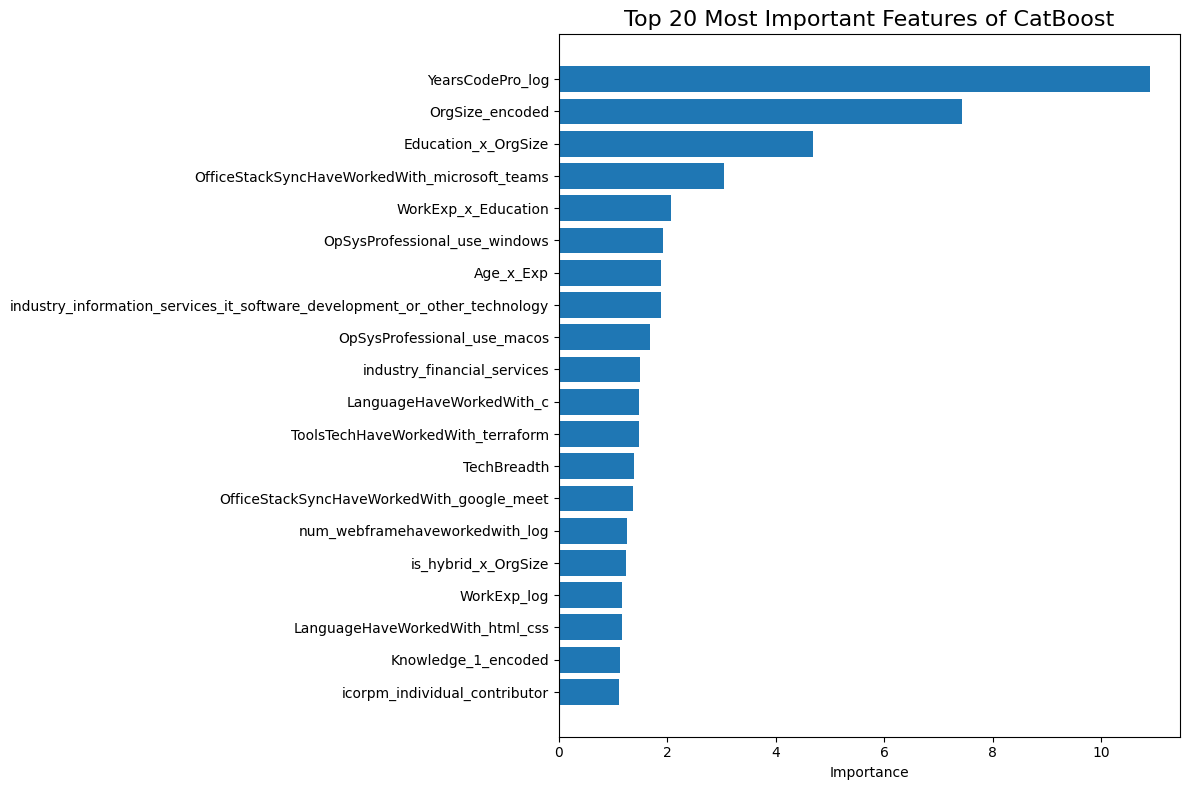

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Get best model name based on highest R²
best_model_name = performance_df['r2'].idxmax()
print(f"Best model based on R²: {best_model_name}")

# Extract best model from the models dictionary
best_model = models[best_model_name]

# Get feature importances (works for tree-based models)
feature_importance = pd.DataFrame({
    'feature': X_train_fe.columns,
    'importance': best_model.feature_importances_
})

# Sort and get top 20 features
top_20_features = feature_importance.sort_values('importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(12, 8))
plt.barh(top_20_features['feature'], top_20_features['importance'])
plt.title(f"Top 20 Most Important Features of {best_model_name}", fontsize=16)
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Key Insights**

* **YearsCodePro_log** is by far the most important feature.

* **OrgSize_encoded** and **Education × OrgSize** are also very high up. This tells us that both the size of the company and how it combines with someone’s education level are important in predicting salary. This make sense as bigger companies and higher education usually mean better pay.

* **Microsoft Teams usage** ranks high. It likely signals someone works in a corporate or enterprise setup, which tends to pay more. So tools aren't just noise, they can hint at job environment.

* **WorkExp × Education** and **Age × Experience** both show up as useful interactions.

* **Tech skills like C, Terraform, and HTML/CSS** are still contributing. These might be proxies for certain roles (e.g. C = embedded systems, Terraform = DevOps/infrastructure).

* **is_hybrid × OrgSize** is interesting. It suggests hybrid work setups in large companies might be associated with better salaries.

* Lastly, even softer signals like **self-assessed knowledge levels** and whether someone is an **individual contributor** seem to matter.

# Feature Selection and Retraining

**Strategy**

* We identified low-importance features using a threshold of `importance < 0.01` from the best model’s `.feature_importances_`.
* These features were dropped from both training and test sets to create `X_train_pruned` and `X_test_pruned`.
* Each model was retrained on the pruned feature set to evaluate performance impacts post-reduction.
* We used `evaluate_model()` to compare updated metrics (`r2`, `adjusted_r2`, `rmse`, `mae`) against the original baseline.
* This step tested whether removing weak signals improved generalization or helped simplify models without sacrificing accuracy.


In [37]:
# Identify low-importance features
useless_features = feature_importance[feature_importance['importance'] < 0.01]['feature'].tolist()

# Create pruned feature sets by dropping useless features
X_train_pruned = X_train_fe.drop(columns=useless_features)
X_test_pruned = X_test_fe.drop(columns=useless_features)

In [38]:
# Retrain the models using purned sets
results_pruned = {}

for name, model in models.items():
    print(f"\nTraining {name} after dropping low-importance features...")
    model.fit(X_train_pruned, y_train)
    y_pred = model.predict(X_test_pruned)
    results_pruned[name] = evaluate_model(y_test, y_pred, name, n_features=X_test_pruned.shape[1])


Training Random Forest after dropping low-importance features...

Random Forest Performance Metrics:
R² Score: 0.3606
Adjusted R²: 0.2989
RMSE: $63,469.59
MAE: $44,822.44

Training XGBoost after dropping low-importance features...

XGBoost Performance Metrics:
R² Score: 0.4174
Adjusted R²: 0.3612
RMSE: $60,583.36
MAE: $42,870.49

Training LightGBM after dropping low-importance features...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2027
[LightGBM] [Info] Number of data points in the train set: 8911, number of used features: 196
[LightGBM] [Info] Start training from score 161348.576366

LightGBM Performance Metrics:
R² Score: 0.4111
Adjusted R²: 0.3543
RMSE: $60,911.91
MAE: $43,077.45

Training CatBo

In [39]:
# Create performance comparison DataFrame
performance_df_pruned = pd.DataFrame(results_pruned).T
print("\nPruned Model Performance Comparison:")
display(performance_df_pruned.sort_values('r2', ascending=False))


Pruned Model Performance Comparison:


,r2,adjusted_r2,rmse,mae
CatBoost,0.420274,0.364328,60434.832458,42227.691600
XGBoost,0.417421,0.361200,60583.360295,42870.486499
LightGBM,0.411085,0.354253,60911.907137,43077.445820
Gradient Boosting,0.406124,0.348813,61167.921347,42945.229992
Random Forest,0.360590,0.298884,63469.591481,44822.437262
Lasso,0.350889,0.288247,63949.265838,44556.799958


In [40]:
# Count features before and after pruning
feature_counts = pd.DataFrame({
    'Model': models.keys(),
    'Before Cleanup': [X_train_fe.shape[1]] * len(models),  # original feature count
    'After Cleanup': [X_train_pruned.shape[1]] * len(models)  # pruned feature count
})

display(feature_counts)

,Model,Before Cleanup,After Cleanup
0,Random Forest,214,196
1,XGBoost,214,196
2,LightGBM,214,196
3,CatBoost,214,196
4,Gradient Boosting,214,196
5,Lasso,214,196


**Observations from Pruned Model Performance**

* `CatBoostRegressor` remained the top performer post-pruning, with stable `r2` (0.42) and slightly lower `rmse` and `mae`.
* `XGBoost` improved marginally in both `r2` and `adjusted_r2`, suggesting some benefit from removing noise features.
* `LightGBM` and `Gradient Boosting` maintained performance with negligible change, indicating robustness to irrelevant features.
* `Random Forest` saw a small gain in `adjusted_r2`, but overall performance remained lower than boosting models.
* `LassoCV` showed no improvement, consistent with its linear nature and dependence on regularization for feature selection.
* Overall, pruning reduced the feature space from 214 to 196 across all models without harming accuracy.

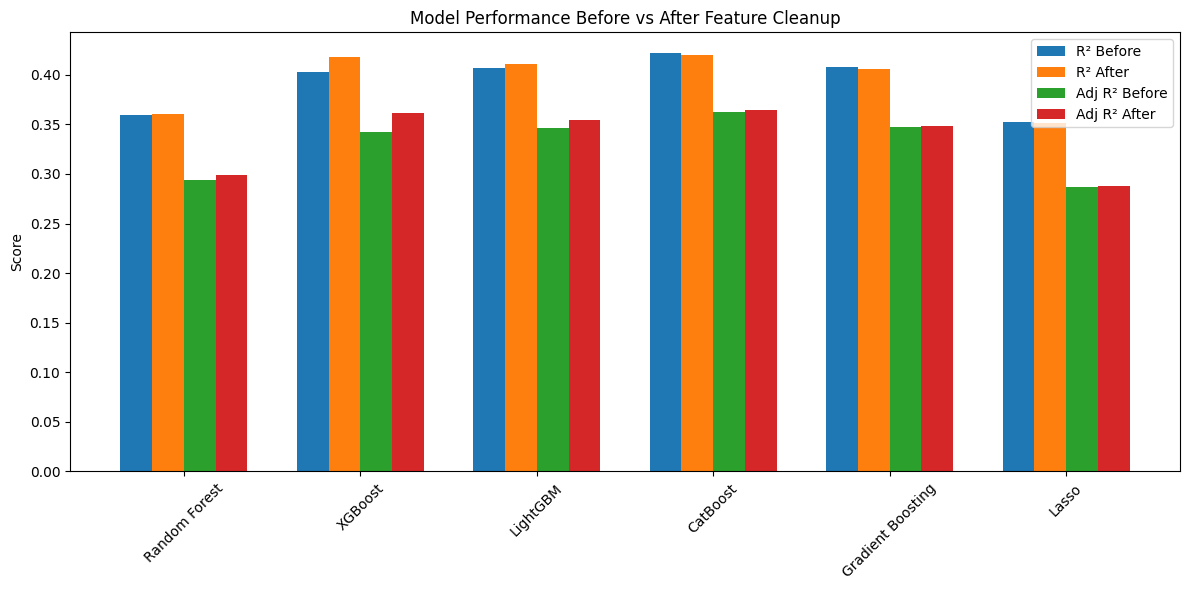

In [41]:
# Common model names
models = performance_df.index.tolist()

# Extract metric values
r2_before = performance_df.loc[models, 'r2'].values
r2_after = performance_df_pruned.loc[models, 'r2'].values
adj_r2_before = performance_df.loc[models, 'adjusted_r2'].values
adj_r2_after = performance_df_pruned.loc[models, 'adjusted_r2'].values

# Plot settings
x = np.arange(len(models))
width = 0.18

plt.figure(figsize=(12, 6))
plt.bar(x - width*1.5, r2_before, width, label='R² Before')
plt.bar(x - width/2,  r2_after,  width, label='R² After')
plt.bar(x + width/2,  adj_r2_before, width, label='Adj R² Before')
plt.bar(x + width*1.5, adj_r2_after,  width, label='Adj R² After')

plt.xticks(x, models, rotation=45)
plt.ylabel("Score")
plt.title("Model Performance Before vs After Feature Cleanup")
plt.legend()
plt.tight_layout()
plt.show()

**Observations from Performance Comparison Plot**

* `XGBoost` showed the most improvement in both `r²` and `adjusted r²` after pruning, indicating sensitivity to irrelevant features.
* `LightGBM` and `CatBoost` maintained stable scores with only minor positive shifts, confirming their robustness to noise.
* `RandomForest` remained nearly unchanged across all metrics, suggesting its built-in feature randomness already handles noise.
* `Gradient Boosting` experienced negligible impact, with scores before and after remaining tightly aligned.
* `LassoCV` slightly declined across both metrics, reinforcing its dependence on strong linear signals.
* Overall, feature cleanup did not harm performance and in some cases slightly improved generalization.

# Hyperparameter Tuning for Top Models

**Strategy**

* We focused tuning efforts on the top three performers: CatBoost, LightGBM, and Gradient Boosting.
* A small but targeted search space was defined for each model, balancing depth, learning rate, and regularization.
* Parameters included model-specific controls like `num_leaves` (LightGBM), `depth` (CatBoost), and `subsample` (GB).
* `RandomizedSearchCV` was selected for its efficiency, given the limited parameter space and computational cost.
* Each model was initialized with a fixed number of estimators (`n_estimators=300`) to ensure consistency across comparisons.
* This tuning step aimed to refine each model’s performance without overfitting or introducing excessive complexity.

In [52]:
# Dictionary to store tuned models and their results
tuned_models = {}

In [53]:
# Define parameter grids for each model
catboost_params = {
    'depth': [6, 10],
    'learning_rate': [0.03, 0.1],
    'iterations': [300],
    'l2_leaf_reg': [3, 5]
}

lightgbm_params = {
    'num_leaves': [31, 63],
    'learning_rate': [0.03, 0.1],
    'n_estimators': [300],
    'reg_alpha': [0.1],
    'reg_lambda': [0.1]
}

gb_params = {
    'n_estimators': [300],
    'learning_rate': [0.03, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2],
    'subsample': [0.8, 1.0]
}

In [54]:
from sklearn.model_selection import RandomizedSearchCV

# Tune CatBoost
print("Tuning CatBoost...")
catboost_model = CatBoostRegressor(random_state=42, verbose=0)

catboost_random = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=catboost_params,
    n_iter=4,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

catboost_random.fit(X_train_fe, y_train)

print("\nBest CatBoost parameters:", catboost_random.best_params_)
print("Best CV score:", catboost_random.best_score_)

# Store best model
tuned_models['CatBoost'] = catboost_random.best_estimator_

# Evaluate on test set
y_pred = catboost_random.predict(X_test_fe)
results['CatBoost (Tuned)'] = evaluate_model(y_test, y_pred, "CatBoost (Tuned)", n_features=X_test.shape[1])

Tuning CatBoost...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best CatBoost parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 300, 'depth': 6}
Best CV score: 0.41276192340597356

CatBoost (Tuned) Performance Metrics:
R² Score: 0.4221
Adjusted R²: 0.3632
RMSE: $60,341.51
MAE: $42,175.78


In [55]:
# Tune LightGBM
print("\nTuning LightGBM...")
lightgbm_model = LGBMRegressor(random_state=42)

lightgbm_random = RandomizedSearchCV(
    estimator=lightgbm_model,
    param_distributions=lightgbm_params,
    n_iter=4,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

lightgbm_random.fit(X_train_fe, y_train)

print("\nBest LightGBM parameters:", lightgbm_random.best_params_)
print("Best CV score:", lightgbm_random.best_score_)

# Store best model
tuned_models['LightGBM'] = lightgbm_random.best_estimator_

# Evaluate on test set
y_pred = lightgbm_random.predict(X_test_fe)
results['LightGBM (Tuned)'] = evaluate_model(y_test, y_pred, "LightGBM (Tuned)", n_features=X_test.shape[1])


Tuning LightGBM...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2063
[LightGBM] [Info] Number of data points in the train set: 8911, number of used features: 214
[LightGBM] [Info] Start training from score 161348.576366

Best LightGBM parameters: {'reg_lambda': 0.1, 'reg_alpha': 0.1, 'num_leaves': 31, 'n_estimators': 300, 'learning_rate': 0.03}
Best CV score: 0.41633317126023

LightGBM (Tuned) Performance Metrics:
R² Score: 0.4225
Adjusted R²: 0.3637
RMSE: $60,316.11
MAE: $42,171.12


In [56]:
# Tune Gradient Boosting
print("\nTuning Gradient Boosting...")
gb_model = GradientBoostingRegressor(random_state=42)

gb_random = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=gb_params,
    n_iter=4,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

gb_random.fit(X_train_fe, y_train)

print("\nBest Gradient Boosting parameters:", gb_random.best_params_)
print("Best CV score:", gb_random.best_score_)

# Store best model
tuned_models['Gradient Boosting'] = gb_random.best_estimator_

# Evaluate on test set
y_pred = gb_random.predict(X_test_fe)
results['Gradient Boosting (Tuned)'] = evaluate_model(y_test, y_pred, "Gradient Boosting (Tuned)", n_features=X_test.shape[1])


Tuning Gradient Boosting...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best Gradient Boosting parameters: {'subsample': 1.0, 'n_estimators': 300, 'min_samples_split': 2, 'max_depth': 3, 'learning_rate': 0.1}
Best CV score: 0.3943150822805089

Gradient Boosting (Tuned) Performance Metrics:
R² Score: 0.4092
Adjusted R²: 0.3490
RMSE: $61,007.05
MAE: $42,836.39



Final Model Performance Comparison:


,r2,adjusted_r2,rmse,mae
LightGBM (Tuned),0.422550,0.363690,60316.106688,42171.121499
CatBoost (Tuned),0.422063,0.363154,60341.512270,42175.784416
CatBoost,0.421705,0.362759,60360.218991,42166.270703
Gradient Boosting (Tuned),0.409244,0.349029,61007.047806,42836.388209
Gradient Boosting,0.408133,0.347805,61064.376037,42980.688670
LightGBM,0.406770,0.346302,61134.661180,43268.753134
XGBoost,0.403138,0.342300,61321.509030,43461.884859
Random Forest,0.359580,0.294302,63519.695147,44892.294833
Lasso,0.352520,0.286523,63868.861195,44522.006430


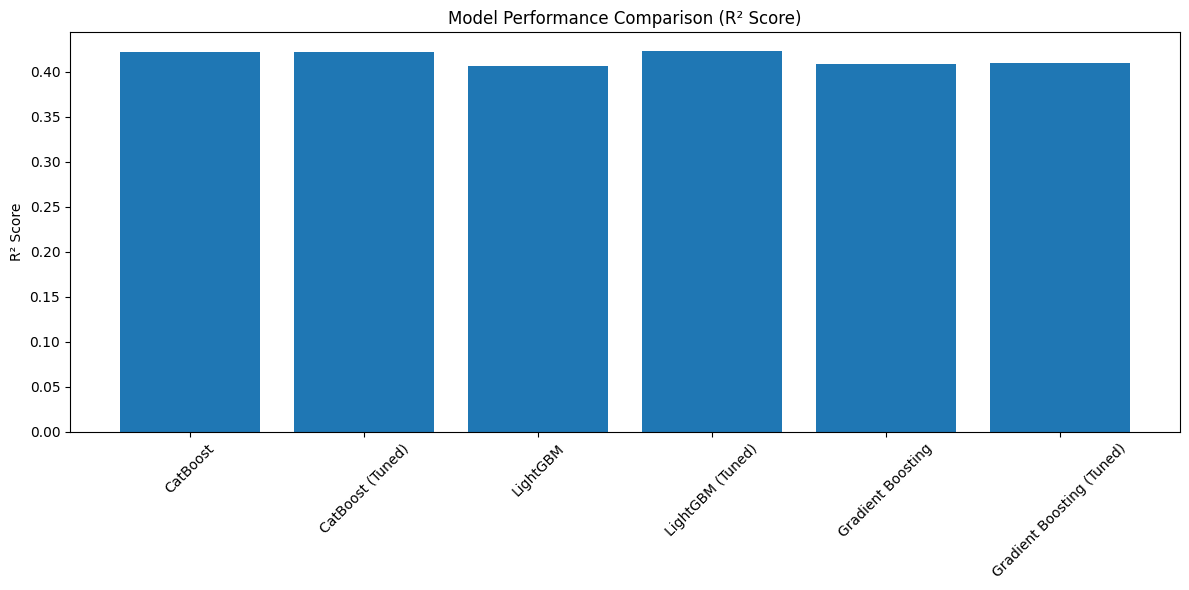

In [57]:
# Compare all model performances
performance_df = pd.DataFrame(results).T
print("\nFinal Model Performance Comparison:")
display(performance_df.sort_values('r2', ascending=False))

# Plot comparison of original vs tuned models
plt.figure(figsize=(12, 6))
models_to_compare = ['CatBoost', 'CatBoost (Tuned)',
                    'LightGBM', 'LightGBM (Tuned)',
                    'Gradient Boosting', 'Gradient Boosting (Tuned)']
r2_scores = [performance_df.loc[model, 'r2'] for model in models_to_compare]

plt.bar(models_to_compare, r2_scores)
plt.xticks(rotation=45)
plt.title('Model Performance Comparison (R² Score)')
plt.ylabel('R² Score')
plt.tight_layout()
plt.show()

**Final Performance Comparison**

* LightGBM (tuned) achieved the highest R² and the lowest error metrics, confirming that tuning made a measurable impact.
* CatBoost (tuned) followed closely, showing slight improvements after adjusting depth and regularization settings.
* Gradient Boosting also improved, but the gains were smaller, suggesting it was less sensitive to the parameter space we explored.
* The tuned versions of LightGBM and CatBoost stood out as the most stable and consistent options.
* Tuning reinforced their reliability and gave us greater confidence in selecting them as final candidates.

# Key Takeaways and Future Enhancements

* We observed clear performance gains after applying advanced feature engineering, interaction terms, and model tuning.
* These steps helped capture non-linear patterns and improved the model’s ability to generalize.
* To build on this, we plan to expand the dataset beyond 2023 to reduce temporal bias and improve coverage.
* Adding contextual data such as historical salary trends, cost of living, or job market indicators may further boost prediction accuracy.
* We are also considering a shift from point estimates to predicting salary ranges, making the outputs more practical and aligned with real-world expectations.
